<a href="https://colab.research.google.com/github/sjeena0722/TotochTeam1/blob/main/day_4/day4_%EC%8B%A4%EC%8A%B5_%EC%86%90%EC%A7%84%EC%95%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/AIFFEL-GN-2nd/TotochTeam1/blob/main/day_4/day4_%EC%8B%A4%EC%8A%B5_%5B%EC%9D%B4%EB%A6%84%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이웃집 토토치 파이토치 : Day 4

📢 해당 게시물은 파이토치 공식 튜토리얼 중 
[컴퓨터 비전(VISION)을 위한 전이학습](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)를 읽고 직접 작성해보는 실습 노트북입니다.  

In [1]:
from IPython.display import Image
Image("./img/image.png")

🔎 Transfer learning은 무엇이고 pre-trained과 다른점이 무엇일까요?   
👉 전이학습 : 관련 작업에 대해 이미 훈련된 모델의 일부를 가져와 새 모델에서 재사용함으로써 손쉽게 데이터를 구축하는 기술 / 이미 dataset(A Task)에 학습이 진행된 pretrained model의 가중치(weight)를 가져와서 다른 dataset(B Task)에 적용을 하는 것

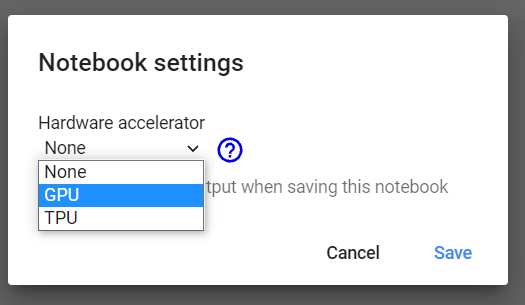

In [ ]:
Image("./img/gpu.png")

시작하기 전에 런타임을 GPU로 바꿔주세요!!

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import copy

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

plt.ion()   # 대화형 모드

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCH = 10
BATCH_SIZE = 128 # 시각화를 이쁘게 하려면 4개로 해주세요
FC_LAYER_SIZE = 128
LR = 0.01
DROOUT = 0.5
OPTIMIZER = 'sgd'

## 1) Dataset 준비

Transfer Leaning을 준비하기 위해서는 (1)내가 원하는 Dataset 과 (2) pre-trained model 이 필요합니다.

In [4]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

train_dataset = datasets.CIFAR10(root = '../CIFAR10', train = True, 
                               download = True, transform = train_transform) 

test_dataset = datasets.CIFAR10(root = '../CIFAR10', train = False,
                               download = True, transform = test_transform)

# Subset을 사용하면 Dataset의 부분 집합만 가져올 수 있음.
train_sub_dataset = Subset(train_dataset, indices=range(0, len(train_dataset), 5))
test_sub_dataset = Subset(test_dataset, indices=range(0, len(test_dataset), 5))

train_loader = DataLoader(dataset = train_sub_dataset, batch_size = BATCH_SIZE,
                         shuffle = True, num_workers=2)

test_loader = DataLoader(dataset = test_sub_dataset,
                         batch_size = BATCH_SIZE)

dataloaders = {
    'train':train_loader,
    'test':test_loader
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../CIFAR10/cifar-10-python.tar.gz to ../CIFAR10
Files already downloaded and verified


#### A. 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


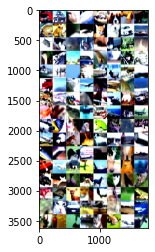

In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## 2) Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

## 3) Fine-tuning 모델

In [9]:
finetun_model = models.resnet18(pretrained=True)
num_ftrs = finetun_model.fc.in_features
finetun_model._fc = nn.Linear(num_ftrs, 10)  # fc 레이어 교체

finetun_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(finetun_model.parameters(), lr=LR, momentum=0.9)

## 4) 학습 진행하기

In [10]:
model = finetun_model

train_acc_list =[]
train_loss_list = []
test_acc_list = []
test_loss_list = []

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in tqdm(range(EPOCH)):
    print('Epoch {}/{}'.format(epoch, EPOCH - 1))
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            # print(labels)
            # print(labels.shape)
            # break
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        print('>> Phase: ', phase)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'train':
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
        else:
            test_acc_list.append(epoch_acc)
            test_loss_list.append(epoch_loss)
            
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best test Acc: {:4f}'.format(best_acc))

# load best model weights
# model.load_state_dict(best_model_wts)

torch.save(best_model_wts , './pretrained_vgg_orignal_cifar10.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
--------------------
>> Phase:  train
train Loss: 2.1169 Acc: 0.3965
>> Phase:  test
test Loss: 1.3066 Acc: 0.5510
Epoch 1/9
--------------------
>> Phase:  train
train Loss: 1.1752 Acc: 0.5904
>> Phase:  test
test Loss: 0.9018 Acc: 0.7100
Epoch 2/9
--------------------
>> Phase:  train
train Loss: 0.9387 Acc: 0.6717
>> Phase:  test
test Loss: 0.6645 Acc: 0.7765
Epoch 3/9
--------------------
>> Phase:  train
train Loss: 0.8132 Acc: 0.7195
>> Phase:  test
test Loss: 0.5505 Acc: 0.8150
Epoch 4/9
--------------------
>> Phase:  train
train Loss: 0.7225 Acc: 0.7420
>> Phase:  test
test Loss: 0.5201 Acc: 0.8250
Epoch 5/9
--------------------
>> Phase:  train
train Loss: 0.6738 Acc: 0.7626
>> Phase:  test
test Loss: 0.5099 Acc: 0.8345
Epoch 6/9
--------------------
>> Phase:  train
train Loss: 0.6075 Acc: 0.7904
>> Phase:  test
test Loss: 0.5133 Acc: 0.8385
Epoch 7/9
--------------------
>> Phase:  train
train Loss: 0.5974 Acc: 0.7929
>> Phase:  test
test Loss: 0.4675 Acc: 0.8485


## 5) 학습 결과 시각화

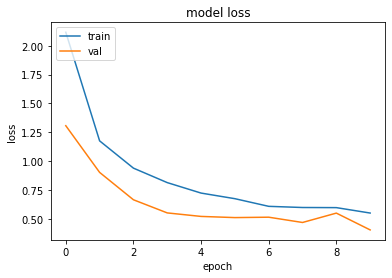

In [11]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

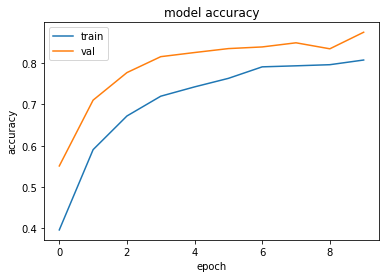

In [12]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()